
# Arduino Week 1 Time Series Plotting Jupyter Notebook

Author: Jun Ho Lee  
Last Update: 09/23/2019

**This code resamples the raw data into hourly (customizable) frequencies for week 1 paradigms (Port Hab / CCue / RFC)**

- These paradigms are the ones with only single ':' as a delimiter
- Does NOT contain counter values


____
<a id='Goals'></a>

### Objective: Plot metrics binned by hour
- Look at the data binned by specific frequencies (hour / 4hours / day etc.) 
- Originally needed for looking at # of pokes during the light cycle (to see how much mice poke during the light cycle) 
- Extended functionality (generalized) so that I can look at custom-resampled frequencies

**References: Error Handling Docs**
1. [Built-in Exceptions](https://docs.python.org/3/library/exceptions.html)
2. [Errors and Exceptions](https://docs.python.org/3/tutorial/errors.html)
3. [Manually Raising an Error in Python](https://stackoverflow.com/questions/2052390/manually-raising-throwing-an-exception-in-python)
4. [Hierarchical Indexing Documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html)


### Important Note:

> Do **NOT** save or modify the original csv file!!! 
Modifying the csv file will lead to truncation of leading zeros in the file, which will mess up the analysis! 


<a id='Table of Contents'></a>
___
* * * * * * * * * 

0. <a href='#Goals'>Objectives</a>

## Table of Contents


1. <a href='#Function List'>List of Functions</a>

2. <a href='#data wrangling'>Initial Data Wrangling</a>

3. <a href='#metric output'>Metric Output</a>

3. <a href='#metric checkpoint'>Save Metric Output to CSV (Checkpoint)</a>



**Appendix:**  
1. <a href='#Event Code'>Event Codes</a> (Run this First!!)

<a id='Function List'></a>
___
    
### 1. List of Functions

*A. <a href='#data extraction'>Data Extraction and Parsing</a>*
1. <a href='#return_header_dict'>return-multi-header-dict</a>
2. <a href='#return_body_df'>return-multi-body-df</a>
3. <a href='#get_start_end_time'>get-start-end-time</a>
4. <a href='#return_multi_dt'>return-multi-dt-df</a> 
5. <a href='#fill_counter_datetime_col'>fill-counter-datetime-col</a> 
6. <a href='#return_multi_parsed_dt'>return-multi-parsed-dt-df</a> **- NOT USED**
7. <a href='#final wrapper function'>final-m-header-and-parsed-dt-df</a> **- NOT USED**


*B. <a href='#metric calculation'>Metric Calculations</a>* **- NOT USED - DELETED**
1. <a href='#counts_during_window'>counts-during-window</a> **- NOT USED - DELETED**
2. <a href='#count_events'>count-events</a> **- NOT USED - DELETED**


*C. <a href='#time_series'>Time-Series Plotting</a>*

1. <a href='#hourly_resampled'>hourly-resampled-df</a>


### *For Function Testing Purposes*
- to determine which function throws an error before running the wrapper function

###### Import Basic Libraries


In [1]:
import numpy as np
import pandas as pd
from natsort import natsorted, ns
from datetime import datetime
# import matplotlib.pyplot as plt
# import seaborn as sns

file = "../0920 RFC.csv" 
test_multi_df = pd.read_csv(file, header=[0,1], index_col=[0])


<a id='data extraction'></a>
___
#### A. Data Extraction and Parsing


<a id='return_header_dict'></a>

**1: return_multi_header_dict (multi_df)**

- :**multi_df:** multilevel dataframe that we created from "import_files.py"
- **:return:** `m_head_dict`: nested dictionary of headers $\rightarrow$ {box number(keys): {header info(values)}}

In [2]:
# # Will only need the initial "MultiLevel Dataframe" to run subsequent codes!!
def return_multi_header_dict(multi_df):
    
    m_head_dict = {}
    box_numbers = multi_df.columns.levels[0]  # Returns a "Frozen List" 
    sorted_box_nums = natsorted(box_numbers) # outputs a list of sorted box numbers

    for i in range(len(sorted_box_nums)):
        box_num = sorted_box_nums[i]
        ind_df = multi_df.loc[:, box_num]  # individual dataframe (box is type 'string')

        ind_df = ind_df.dropna(how='all')

        start_code_idx = ind_df.index[ind_df.event_code == '0113'].tolist()[0]  # the list will only contain ONE element
        end_date_info = ind_df[-2:]  # last two rows will always be end date info

        head = ind_df[:start_code_idx]

        ind_head = pd.concat([head, end_date_info], axis=0)   # header dictionary requires end date/time info so need to concatenate the top and bottom dfs
        ind_head['timestamp'] = ind_head['timestamp'].str.strip()

        # # {first column: second column}
        ind_header_dict = {row[0]: row[1] for row in ind_head.values}  # .values --> transforms into numpy array

        m_head_dict[box_num] = ind_header_dict

    return m_head_dict


In [3]:
test_m_head_dict = return_multi_header_dict(test_multi_df)

<a href='#Function List'>Back to List of Functions</a>

<a id='return_body_df'></a>

**2: return_multi_body_df (multi_df):**

- **:multi_df:** multilevel dataframe that we created from "import_files.py"
- **:returns:** `m_body_df`: multilevel dataframe of the BODY portion of data  

*BODY*: FROM the first IR initialization (9070) TO the second to last row of the original dataframe (excluding end date/time)

In [6]:
# Will only need the initial "MultiLevel Dataframe" to run subsequent codes!!

def return_multi_body_df(multi_df, columns):

    result = []; box_arr = []
    box_numbers = multi_df.columns.levels[0]
    sorted_box_nums = natsorted(box_numbers) # outputs a list of sorted box numbers
    
    for i in range(len(sorted_box_nums)):  # for all the boxes, (outermost index is box number)
        box_num = sorted_box_nums[i]
        ind_df = multi_df.loc[:, box_num]  # individual dataframe

        ind_df = ind_df.dropna(how='all')
#         ind_df['event_code'] = ind_df['event_code'].astype('str')  # Changed

        # Extracting ACTUAL BODY
        header_end_idx = ind_df.loc[ind_df[ind_df.columns[0]] == '9070'].index[0]
        body_start_idx = header_end_idx + 1

        body = ind_df[body_start_idx:-2].reset_index(drop=True)
        body['timestamp'] = pd.to_numeric(body['timestamp'])
        body['event_string'] = body['event_code'].map(event_code_dict)

        body = body[columns]  # 4 columns

        box_arr.append(box_num)
        result.append(body)

    m_body_df = pd.concat(result, axis=1, keys=box_arr, names=['Box Number', 'Columns'])

    return m_body_df


<a href='#Event Code'>Event Codes</a> (Run this First!!)

In [7]:
# Use this for Port Habituation + Continuous Cue etc. (paradigms that don't have counter columns)
columns = ['event_string', 'event_code', 'timestamp']  

# Use this for paradigms that have counter values
# columns = ['event_string', 'event_code', 'timestamp', 'counter']

test_m_body_df = return_multi_body_df(test_multi_df, columns)

<a href='#Function List'>Back to List of Functions</a>

<a id='get_start_end_time'></a>

**3. get_start_end_time (m_head_dict):**

- **:m_head_dict:** nested dictionary of headers for all boxes
- **:returns:** `start_end_time_dict`: dictionary of datetime tuples {box_num: (start_time, end_time)}


In [8]:
def get_start_end_time(m_head_dict):

    start_end_time_dict = {}

    box_numbers = list(m_head_dict)   # keys of the header dictionary --> box numbers
    for i in range(len(box_numbers)):
        box_num = box_numbers[i]
        
        # Start Datetime
        start_datetime = m_head_dict[box_num]['Start Date'] + " " + m_head_dict[box_num]['Start Time']
        start_datetime = start_datetime.replace("-",":")

        # End Datetime
        end_datetime = m_head_dict[box_num]['End Date']  + " " + m_head_dict[box_num]['End Time']
        end_datetime = end_datetime.replace("-",":")

        start_time = datetime.strptime(start_datetime, '%m/%d/%Y %H:%M:%S')
        end_time = datetime.strptime(end_datetime, '%m/%d/%Y %H:%M:%S')

        start_end_time_dict[box_num] = (start_time, end_time)  # saves it as a tuple of datetimes
        # print(start_time, end_time)

    return start_end_time_dict
    

In [9]:
test_start_end_time_dict = get_start_end_time(test_m_head_dict)

<a href='#Function List'>Back to List of Functions</a>

<a id='return_multi_dt'></a>

**4. return_multi_dt_df (m_head_dict, m_body_df, start_end_time_dict):**
- **:m_head_dict:** dictionary for all boxes
- **:m_body_df:** multilevel dataframe of the BODY
- **:start_end_time_dict:** nested dictionary of start/end time tuples
- **:returns:** `m_dt_df`: multilevel datetime dataframe


In [10]:

def return_multi_dt_df(m_head_dict, m_body_df, start_end_time_dict):

    result = []; box_arr = list(m_body_df.columns.levels[0])
    midx_shape = m_body_df.columns.levshape   # (returns a tuple)
    
    # # # Exception Handling 
    if (len(m_head_dict) != midx_shape[0]):   # This indicates the number of boxes
        raise ValueError('Number of boxes in dictionary and dataframe does not match')

    for i in range(len(box_arr)):  # for all the boxes in box_array
        box_num = box_arr[i]    
        ind_df = m_body_df.loc[:, box_num]  # individual dataframe / box_num --> class 'string'
    
        ind_df = ind_df.dropna(how='all')
        
        start_time = start_end_time_dict[box_num][0]
        end_time = start_end_time_dict[box_num][1]
        
        # # Broadcast new columns 
        ind_df['datetime_realtime'] = start_time + pd.to_timedelta(pd.to_numeric(ind_df['timestamp']), unit='ms')
        ind_df['day'] = ind_df['datetime_realtime'].dt.day
        ind_df['hour'] = ind_df['datetime_realtime'].dt.hour  # using the .dt accessor to access datetime object
    
        # box_arr.append(box_num)
        result.append(ind_df)
    
    m_dt_df = pd.concat(result, axis=1, keys=box_arr, names=['Box Number', 'Columns'])
    
    return m_dt_df
    

In [11]:
test_m_dt_df = return_multi_dt_df(test_m_head_dict, test_m_body_df, test_start_end_time_dict)
# test_m_dt_df

<a href='#Function List'>Back to List of Functions</a>

<a id='fill_counter_datetime_col'></a>

**5. fill_counter_datetime_col (m_dt_df):**
- **:m_dt_df:** multilevel datetime dataframe
- **:returns:** `m_dt_df_impute`: multilevel dataframe after datetime imputation (backfilled + ffilled) 


#### This is a necessary imputation step since counter values don't have timestamps! (and indexing will be impossible without valid timestamps) 
- Will use ffill if last row in the parsed dataframe is a counter value 
- Will use bfill if first row in the parsed dataframe is a counter value

(without this step, tried to parse the dataframe according to the indices, but that ran into problems as well... -> thought it would be easier to just bfill / ffill the missing datetime values for the counters) 


In [12]:

def fill_counter_datetime_col(m_dt_df):
    
    result = []; box_arr = list(m_dt_df.columns.levels[0])
#     midx_shape = m_dt_df.columns.levshape   # (returns a tuple)
    
    for i in range(len(box_arr)):  # for all the boxes in box_array
        box_num = box_arr[i]    
        ind_df = m_dt_df.loc[:, box_num]  # individual dataframe / box_num --> class 'string'
    
        ind_df = ind_df.dropna(how='all')
        
        first_row_timestamp = ind_df.iloc[0]['timestamp']  
        last_row_timestamp = ind_df.iloc[-1]['timestamp'] 
        
        ind_df_impute = ind_df.copy()

        # # Two if statements to ensure columns get filled in every case 
        # # Even if BOTH first row and last row are NaN values
        
        if pd.isnull(first_row_timestamp):
            ind_df_impute['datetime_filled'] = ind_df_impute.datetime_realtime.fillna(method='bfill')

        # # Column updating! 
        if pd.isnull(last_row_timestamp): 
            ind_df_impute['datetime_filled'] = ind_df_impute['datetime_filled'].fillna(method='ffill')
            
        # # If none of the first/last rows are none, just use bfill method
        else:
            ind_df_impute['datetime_filled'] = ind_df_impute.datetime_realtime.fillna(method='bfill')

        result.append(ind_df_impute)
    
    # box_arr from above (before the for loop)
    m_dt_df_imputed = pd.concat(result, axis=1, keys=box_arr, names=['Box Number', 'Columns'])
            
    return m_dt_df_imputed
    

In [13]:
test_m_dt_df_imputed = fill_counter_datetime_col(test_m_dt_df)
# test_m_dt_df_imputed

<a href='#Function List'>Back to List of Functions</a>

<a id='return_multi_parsed_dt'></a>

### **NOTE:** FUNCTION NOT USED
**6. return_multi_parsed_dt_df (m_head_dict, m_dt_df_imputed, start_parsetime, end_parsetime):**
- **:m_head_dict:** dictionary for all boxes
- **:m_dt_df_imputed:** multilevel datetime dataframe after imputation
- **:start_parsetime:** start of parsetime
- **:end_parsetime:** end of parsetime
- **:returns:** `m_parsed_dt_df`: multilevel parsed datetime dataframe (parsed by start/end times)


In [14]:
def return_multi_parsed_dt_df(m_head_dict, m_dt_df_imputed, start_parsetime, end_parsetime):
    
    # # Parse Time Criteria for all files (boxes)
    start_dt = datetime.strptime(start_parsetime, '%Y/%m/%d %H:%M')
    end_dt = datetime.strptime(end_parsetime, '%Y/%m/%d %H:%M')
    
    # # Boilerplate for Multilevel Dataframe
    result = []; box_arr = list(m_dt_df_imputed.columns.levels[0])

    for i in range(len(box_arr)):  
        box_num = box_arr[i]
        ind_df = m_dt_df_imputed.loc[:, box_num]  # individual dataframe
        # No need for conversion to str(box_num) since box_num is already string 

        ind_df = ind_df.dropna(how='all')
        
        # 1. Parse by time
        # # : Problem --> counter values don't have timestamps, thus need to index the dataframe
        # # : Problem solved by imputing datetimes
        p_body = ind_df[(ind_df['datetime_filled'] >= start_dt) & (ind_df['datetime_filled'] <= end_dt)]
        
        result.append(p_body)
        
    m_parsed_dt_df = pd.concat(result, axis=1, keys=box_arr, names=['Box Number', 'Columns'])
        
    return m_parsed_dt_df



In [15]:
print(test_m_head_dict['1']['Start Date'])
print(test_m_head_dict['1']['Start Time'])


09/20/2019
14-31-45


In [16]:

start_parsetime = '2019/09/19 18:00'
end_parsetime = '2019/09/20 06:00'
test_m_parsed_dt_df = return_multi_parsed_dt_df(test_m_head_dict, test_m_dt_df_imputed, start_parsetime, end_parsetime)
# test_m_parsed_dt_df

# test_m_parsed_dt_df['10'].dropna(how='all')

<a href='#Function List'>Back to List of Functions</a>

<a id='final wrapper function'></a>

### **NOTE:** FUNCTION NOT USED

### Wrapper Function (of the above 6 functions)!

**7. final_m_header_and_parsed_dt_df (file, start_parsetime, end_parsetime):**
- **:file:** name of csv file saved from Pycharm
- **:start_parsetime:** start of parsetime
- **:end_parsetime:** end of parsetime
- **:returns:** a tuple *(`m_head_dict, m_parsed_dt_df`)*   
    Note this function returns `m_parsed_dt_df`! (output from last function)
    

**NOTE:** Unncessary for time series plotting since we want the WHOLE data, not just the  parsed information


In [ ]:
def final_m_header_and_parsed_dt_df(file, columns, start_parsetime, end_parsetime):

    # # Reading in multilevel dataframe 
    multi_df = pd.read_csv(file, header=[0,1], index_col=[0])
    
    m_head_dict = return_multi_header_dict(multi_df)
    m_body_df = return_multi_body_df(multi_df, columns)
    
    # # Dictionary of start/end time tuples
    m_start_end_time_dict = get_start_end_time(m_head_dict)
    
    # # Returns dataframe with imputed datetime 
    m_dt_df = return_multi_dt_df(m_head_dict, m_body_df, m_start_end_time_dict)
    m_dt_df_imputed = fill_counter_datetime_col(m_dt_df)
    
    m_parsed_dt_df = return_multi_parsed_dt_df(m_head_dict, m_dt_df_imputed, start_parsetime, end_parsetime)
    
    return m_head_dict, m_parsed_dt_df


No Test Output for this function

<a href='#Function List'>Back to List of Functions</a>

<a id='data wrangling'></a>
___
### 2. Initial Data Wrangling 

**Import Basic Libraries**

In [27]:
# import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns

<a href='#Event Code'>Event Codes</a> (Run this First!!)

## Resampled Frequency Counting

#### Need the `m_dt_df_imputed` as final output!!** 

- (Entire body dataframe with datetime imputed!) 

In [20]:
file = "../0921-0922 RFC.csv" 

# # Use this column list for paradigms WITH Counters (double ::)
# columns = ['event_string', 'event_code', 'timestamp', 'counter']  


# # Use this column list for paradigms WITHOUT Counters (single :)
columns = ['event_string', 'event_code', 'timestamp']  

# # Reading in multilevel dataframe 
multi_df = pd.read_csv(file, header=[0,1], index_col=[0])

m_head_dict = return_multi_header_dict(multi_df)
m_body_df = return_multi_body_df(multi_df, columns)

# # Dictionary of start/end time tuples
m_start_end_time_dict = get_start_end_time(m_head_dict)

# # Returns dataframe with imputed datetime 
m_dt_df = return_multi_dt_df(m_head_dict, m_body_df, m_start_end_time_dict)
m_dt_df_imputed = fill_counter_datetime_col(m_dt_df)

<a href='#Table of Contents'>Back to Table of Contents</a>

<a id='time_series'></a>
___
### 3. Time Series Metrics

**Note: The following codes will only work for event codes you can "count" eg. "7071 / 8271" etc. The Logic will not work for the values in counter variable. (xx49 / xx59) 

**Note:** No need for start/end parsetimes!! 

- to start plotting the data hourly, first start with `m_dt_df_imputed` since this is the dataframe that returns the datetime column "imputed"
- Next, return only the rows that contain the code of interest (for ex. poke array = ['7071/ ' '8071' / '9071] etc. 
- Using that new dataframe, make the datetime as the index and resample by 'H' frequency! 



### Function

**Logic: Parsing by pokes! (7071, 8071, 9071) / Rewards (7271, 8271, 9271)**

References:

Using [.isin()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isin.html) vs [.contains():](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.contains.html)    
[Explanation Here](https://stackoverflow.com/questions/53079487/pandas-what-is-the-difference-isin-and-contains)

[Offset Objects for Resampling](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects)

Later put in an argument for resample frequency in the function `hourly_resampled_df` --> thus won't be `hourly` anymore, but just resampled df

<a id='hourly_resampled'></a>

**1. hourly_resampled_df (m_dt_df_imputed, code_of_interest):**
- **:m_dt_df_imputed:** datetime dataframe that WITH imputed datetimes that is NOT parsed
- **:code_of_interest:** list of interested event codes to count (7071,8071,9071 --> total pokes)
- **:returns:** `final_resampled_df`: resampled dataframe binned by hours on the index and containing box information in columns


In [21]:

def hourly_resampled_df(m_dt_df_imputed, code_of_interest):
    result = []; box_arr = list(m_dt_df_imputed.columns.levels[0])
    
    for i in range(len(box_arr)):  # for all the boxes in box_array
        box_num = box_arr[i]    
        ind_df = m_dt_df_imputed.loc[:, box_num]  # individual dataframe / box_num --> class 'string'
    
        ind_df = ind_df.dropna(how='all')
        
        code_df = ind_df[ind_df['event_code'].isin(code_of_interest)]
        code_df = code_df.set_index('datetime_filled')
        
        resampled_df = code_df.resample('H')['event_code'].count()    # Change here to modify FREQUENCY (2Hours etc.)
        resampled_df.columns = ['count']
        
        result.append(resampled_df)
    
    # Need only one column (box number) for this particular dataframe
    final_resampled_df = pd.concat(result, axis=1, keys=box_arr, names=['Box Number'])

    return final_resampled_df
        

**TESTESTTEST:**

In [23]:
reward_array = ['7271','8271','9271']
total_rewards_by_hour = hourly_resampled_df(m_dt_df_imputed, reward_array)
total_rewards_by_hour.max()

Box Number
1      71.0
2      48.0
3     147.0
4      60.0
5      65.0
6     136.0
7      81.0
8      69.0
9      67.0
10     77.0
dtype: float64

In [29]:
total_rewards_by_hour.head(3)

Box Number,1,2,3,4,5,6,7,8,9,10
datetime_filled,,,,,,,,,,
2019-09-21 14:00:00,NaN,NaN,1.0,NaN,NaN,8,NaN,3,NaN,NaN
2019-09-21 15:00:00,NaN,NaN,0.0,NaN,NaN,0,NaN,5,NaN,NaN
2019-09-21 16:00:00,NaN,NaN,0.0,NaN,NaN,0,NaN,0,NaN,NaN


***Check Start / End Date and Time***

In [30]:

m_head_dict['1']['End Date']

'09/23/2019'

#### Plotting the Time Series with matplotlib

**Plotting individual graphs**

In [ ]:
# a = 7.5
# fig = total_poke_by_hour.loc[:,'1'].plot.bar(color='C0')
# # plt.ylim([0,150]) # Let's not set the ylim since each box has different limits (outliers!)
# fig.axvspan(a, a+12, alpha=0.15, color='black')  # shade in the 12 hours! 
# plt.ylabel("Counts")
# plt.title("Total Poke Counts for Box 4")

# plt.tight_layout()
# plt.show()

# # fig = freq_b5['Count'].plot(kind='bar')

### Hacker way after figuring out that for loop really doesn't work with saving files...

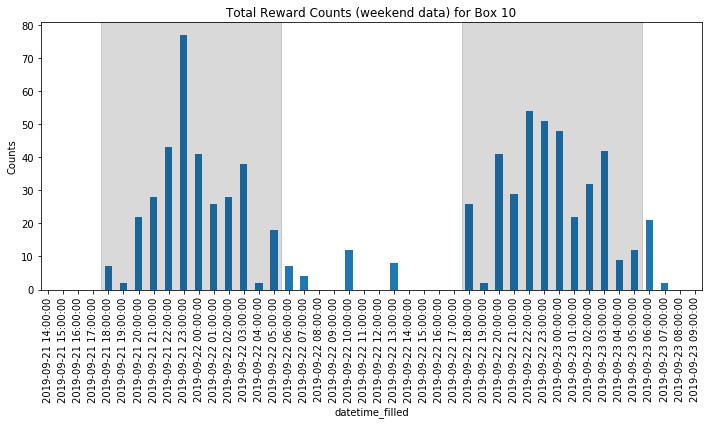

In [32]:
a = 3.5   # CHANGE HERE FOR DARK CYCLE START TIME
b = a + 24  # CHANGE HERE If file contains data for more than 2 days
box_number = '10'

plt.figure(figsize=(10,6))

fig = total_rewards_by_hour.loc[:,box_number].plot.bar(color='C0')

# plt.ylim([0,10]) # Let's not set the ylim since each box has different limits (outliers!)
fig.axvspan(a, a+12, alpha=0.15, color='black')  # shade in the 12 hours! 
fig.axvspan(b, b+12, alpha=0.15, color='black')
plt.ylabel("Counts")
plt.title("Total Reward Counts (weekend data) for Box " + box_number)

file_name = "0921-0922 hourly (RFC)/0921-0922 box"+ box_number +".png"

plt.tight_layout()
# plt.savefig(file_name)
plt.show()

# fig = freq_b5['Count'].plot(kind='bar')

<a id='Event Code'></a>
___
### Appendix:

***Event Codes***

In [5]:

event_code_dict = {'7071' :'L_Poke_Valid_IN',  '7171' :'L_led_Valid_ON',  '7271' :'L_sol_Valid_ON',
                   '7070' :'L_Poke_Valid_OUT', '7170' :'L_led_Valid_OFF', '7270' :'L_sol_Valid_OFF',
                   '8071' :'M_Poke_Valid_IN',  '8171' :'M_led_Valid_ON',  '8271' :'M_sol_Valid_ON',
                   '8070' :'M_Poke_Valid_OUT', '8170' :'M_led_Valid_OFF', '8270' :'M_sol_Valid_OFF',
                   '9071' :'R_Poke_Valid_IN',  '9171' :'R_led_Valid_ON',  '9271' :'R_sol_Valid_ON',
                   '9070' :'R_Poke_Valid_OUT', '9170' :'R_led_Valid_OFF', '9270' :'R_sol_Valid_OFF',

                   '7160' :'L_led_Invalid_OFF',
                   '8160' :'M_led_Invalid_OFF',
                   '9160' :'R_led_Invalid_OFF',

                   '7519' :'L_iw',  '7529' :'L_tw',  '7539' :'L_vw', '7559' :'L_delay_w',
                   '8519' :'M_iw',  '8529' :'M_tw',  '8539' :'M_vw', '8559' :'M_delay_w',
                   '9519' :'R_iw',  '9529' :'R_tw',  '9539' :'R_vw', '9559' :'R_delay_w',

                   '7540' :'Left Omission', '8540' :'Middle Omission', '9540' :'Right Omission',

                   '5520' :'Trial_Window_End',
                   '5521' :'Trial_Window_Start',

                   '0114' :'END'}




<a href='#data wrangling'>Back to Initial Data Wrangling</a>

<a href='#return_body_df'>Back to return-body-df</a>

<a href='#Table of Contents'>Back to Table of Contents</a>